<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [4]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4
!unzip -q faces64c.zip && rm faces64c.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=0942afab658fc3d08016999b227ab47158e138fb27c481b46f2b90cb7ec4b618
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kzpfqy6/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?id=1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4
To: /content/faces64c.zip
22.8MB [00:00, 65.4MB/s]


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [5]:
data_dir = './faces64c/'

In [6]:
def get_dataloader(image_size, batch_size):
    train_ds = ImageFolder(data_dir, transform=tt.Compose([
    #tt.Resize(image_size), уберем ресайз и центер кроп для более быстрой работы
    #tt.CenterCrop(image_size), так как уже есть правильный датасет
    tt.ToTensor(),
    tt.Normalize(*stats)]))

    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.45, 0.45, 0.45)

In [8]:
train_dl = get_dataloader(image_size,batch_size)

In [9]:
next(iter(train_dl))[0].shape

torch.Size([128, 3, 64, 64])

In [52]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break    

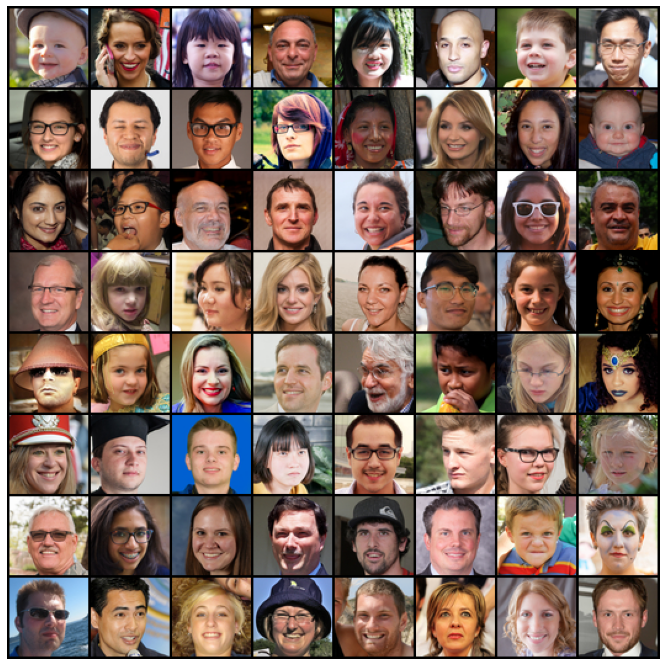

In [53]:
show_batch(train_dl)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
summary(discriminator.to(device),(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [15]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [16]:
summary(generator.to(device),(latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
lr = 4e-4
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.MSELoss(),
}

In [21]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5,0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(device))
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_noise = np.random.uniform(low=0.0,high=0.3, size=real_targets.shape)
            # добавим шум к реальным отметкам
            real_targets -= torch.Tensor(real_noise).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # генерируем изображение
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Подаем фейки в дискриминатор, говоря что это фейки
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_noise = np.random.uniform(low=0.0, high=0.3, size=fake_targets.shape)
            fake_targets += torch.Tensor(fake_noise).to(device)
            #но с шумом
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса дискриминатора
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Обучение генератора
            optimizer["generator"].zero_grad()
            
            # Опять генерим фейки
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Но говорим дискриминатору, что они реальные
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Берем градиент по генератору
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Записываем лоссы
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Сохраним семплы
        if epoch % 100 == 0:
          save_samples(epoch, fixed_latent, show=True)
    
    return losses_g, losses_d, real_scores, fake_scores


Epoch [195/301], loss_g: 0.6977, loss_d: 0.9538, real_score: 0.7894, fake_score: 0.2170



Epoch [196/301], loss_g: 0.6557, loss_d: 1.1591, real_score: 0.7264, fake_score: 0.2700



Epoch [197/301], loss_g: 0.7062, loss_d: 0.9377, real_score: 0.7795, fake_score: 0.2264



Epoch [198/301], loss_g: 0.6970, loss_d: 0.9253, real_score: 0.7936, fake_score: 0.2085



Epoch [199/301], loss_g: 0.7047, loss_d: 0.9060, real_score: 0.7991, fake_score: 0.1943



Epoch [200/301], loss_g: 0.7106, loss_d: 0.9002, real_score: 0.8083, fake_score: 0.1924



Epoch [201/301], loss_g: 0.6983, loss_d: 0.9063, real_score: 0.8092, fake_score: 0.1908
Saving generated-images-0200.png



Epoch [202/301], loss_g: 0.6993, loss_d: 0.9249, real_score: 0.7997, fake_score: 0.1921



Epoch [203/301], loss_g: 0.7030, loss_d: 0.9331, real_score: 0.8041, fake_score: 0.2068



Epoch [204/301], loss_g: 0.6887, loss_d: 0.9424, real_score: 0.7951, fake_score: 0.2007



Epoch [205/301], loss_g: 0.7080, loss_d: 0.9175, real_score: 0.8074, fake_score: 0.1953



Epoch [206/301], loss_g: 0.7036, loss_d: 0.9184, real_score: 0.8042, fake_score: 0.1923



Epoch [207/301], loss_g: 0.7003, loss_d: 0.9134, real_score: 0.8002, fake_score: 0.1923



Epoch [208/301], loss_g: 0.7111, loss_d: 0.9237, real_score: 0.8060, fake_score: 0.1936



Epoch [209/301], loss_g: 0.6971, loss_d: 0.9598, real_score: 0.7893, fake_score: 0.1978



Epoch [210/301], loss_g: 0.6247, loss_d: 1.4931, real_score: 0.6545, fake_score: 0.3620



Epoch [211/301], loss_g: 0.7116, loss_d: 0.9766, real_score: 0.7470, fake_score: 0.2533



Epoch [212/301], loss_g: 0.6862, loss_d: 0.9368, real_score: 0.7749, fake_score: 0.2219



Epoch [213/301], loss_g: 0.6937, loss_d: 0.9259, real_score: 0.7854, fake_score: 0.2039



Epoch [214/301], loss_g: 0.7006, loss_d: 0.9357, real_score: 0.7925, fake_score: 0.2159



Epoch [215/301], loss_g: 0.7034, loss_d: 0.8962, real_score: 0.8034, fake_score: 0.1955



Epoch [216/301], loss_g: 0.7001, loss_d: 0.9099, real_score: 0.8032, fake_score: 0.1929



Epoch [217/301], loss_g: 0.7054, loss_d: 0.9134, real_score: 0.8061, fake_score: 0.1982



Epoch [218/301], loss_g: 0.6926, loss_d: 0.9085, real_score: 0.8023, fake_score: 0.1881



Epoch [219/301], loss_g: 0.6958, loss_d: 0.9826, real_score: 0.7854, fake_score: 0.2204



Epoch [220/301], loss_g: 0.7066, loss_d: 0.9110, real_score: 0.8038, fake_score: 0.1947



Epoch [221/301], loss_g: 0.6981, loss_d: 0.9040, real_score: 0.8075, fake_score: 0.1865



Epoch [222/301], loss_g: 0.7048, loss_d: 0.9127, real_score: 0.8060, fake_score: 0.1887



Epoch [223/301], loss_g: 0.7111, loss_d: 0.9082, real_score: 0.8107, fake_score: 0.1919



Epoch [224/301], loss_g: 0.6985, loss_d: 0.8971, real_score: 0.8152, fake_score: 0.1830



Epoch [225/301], loss_g: 0.7100, loss_d: 0.9172, real_score: 0.8112, fake_score: 0.1887



Epoch [226/301], loss_g: 0.7130, loss_d: 0.9465, real_score: 0.7994, fake_score: 0.2015



Epoch [227/301], loss_g: 0.6997, loss_d: 0.9178, real_score: 0.8038, fake_score: 0.1900



Epoch [228/301], loss_g: 0.7145, loss_d: 0.9425, real_score: 0.8042, fake_score: 0.2034



Epoch [229/301], loss_g: 0.6966, loss_d: 0.9036, real_score: 0.8098, fake_score: 0.1873



Epoch [230/301], loss_g: 0.7126, loss_d: 0.9003, real_score: 0.8149, fake_score: 0.1843



Epoch [231/301], loss_g: 0.7095, loss_d: 0.9334, real_score: 0.8073, fake_score: 0.1994



Epoch [232/301], loss_g: 0.6909, loss_d: 0.9731, real_score: 0.7837, fake_score: 0.2044



Epoch [233/301], loss_g: 0.7129, loss_d: 0.9233, real_score: 0.8070, fake_score: 0.2023



Epoch [234/301], loss_g: 0.7129, loss_d: 0.9047, real_score: 0.8134, fake_score: 0.1909



Epoch [235/301], loss_g: 0.6957, loss_d: 0.9470, real_score: 0.7941, fake_score: 0.2041



Epoch [236/301], loss_g: 0.6998, loss_d: 0.9231, real_score: 0.8021, fake_score: 0.1934



Epoch [237/301], loss_g: 0.7245, loss_d: 0.9385, real_score: 0.8030, fake_score: 0.2038



Epoch [238/301], loss_g: 0.7122, loss_d: 0.9201, real_score: 0.8069, fake_score: 0.1936



Epoch [239/301], loss_g: 0.7047, loss_d: 0.9005, real_score: 0.8106, fake_score: 0.1781



Epoch [240/301], loss_g: 0.7228, loss_d: 0.9355, real_score: 0.8094, fake_score: 0.1954



Epoch [241/301], loss_g: 0.7088, loss_d: 0.9152, real_score: 0.8068, fake_score: 0.1881



Epoch [242/301], loss_g: 0.7172, loss_d: 0.9026, real_score: 0.8156, fake_score: 0.1832



Epoch [243/301], loss_g: 0.7048, loss_d: 0.9201, real_score: 0.8090, fake_score: 0.1881



Epoch [244/301], loss_g: 0.7100, loss_d: 0.9123, real_score: 0.8118, fake_score: 0.1952



Epoch [245/301], loss_g: 0.7084, loss_d: 0.9091, real_score: 0.8085, fake_score: 0.1809



Epoch [246/301], loss_g: 0.7095, loss_d: 0.9211, real_score: 0.8085, fake_score: 0.1891



Epoch [247/301], loss_g: 0.7081, loss_d: 0.9422, real_score: 0.8019, fake_score: 0.2009



Epoch [248/301], loss_g: 0.7171, loss_d: 0.9254, real_score: 0.8096, fake_score: 0.1958



Epoch [249/301], loss_g: 0.7042, loss_d: 0.9032, real_score: 0.8119, fake_score: 0.1823



Epoch [250/301], loss_g: 0.7078, loss_d: 0.9147, real_score: 0.8143, fake_score: 0.1900



Epoch [251/301], loss_g: 0.7017, loss_d: 0.9072, real_score: 0.8090, fake_score: 0.1843



Epoch [252/301], loss_g: 0.7186, loss_d: 0.9289, real_score: 0.8061, fake_score: 0.1996



Epoch [253/301], loss_g: 0.7131, loss_d: 0.9054, real_score: 0.8167, fake_score: 0.1841



Epoch [254/301], loss_g: 0.7026, loss_d: 0.9069, real_score: 0.8125, fake_score: 0.1823



Epoch [255/301], loss_g: 0.6452, loss_d: 1.4405, real_score: 0.7415, fake_score: 0.2809



Epoch [256/301], loss_g: 0.4357, loss_d: 1.7119, real_score: 0.5159, fake_score: 0.4719



Epoch [257/301], loss_g: 0.5478, loss_d: 1.4063, real_score: 0.5724, fake_score: 0.4266



Epoch [258/301], loss_g: 0.7373, loss_d: 1.1216, real_score: 0.6893, fake_score: 0.3269



Epoch [259/301], loss_g: 0.7028, loss_d: 1.0231, real_score: 0.7197, fake_score: 0.2739



Epoch [260/301], loss_g: 0.6992, loss_d: 0.9889, real_score: 0.7482, fake_score: 0.2532



Epoch [261/301], loss_g: 0.6857, loss_d: 0.9320, real_score: 0.7724, fake_score: 0.2270



Epoch [262/301], loss_g: 0.6971, loss_d: 0.9098, real_score: 0.7840, fake_score: 0.2108



Epoch [263/301], loss_g: 0.6751, loss_d: 0.9256, real_score: 0.7833, fake_score: 0.2103



Epoch [264/301], loss_g: 0.6956, loss_d: 0.9043, real_score: 0.8034, fake_score: 0.2010



Epoch [265/301], loss_g: 0.6902, loss_d: 0.9153, real_score: 0.7938, fake_score: 0.1975



Epoch [266/301], loss_g: 0.6940, loss_d: 0.9025, real_score: 0.8104, fake_score: 0.1989



Epoch [267/301], loss_g: 0.6958, loss_d: 0.8985, real_score: 0.8123, fake_score: 0.1916



Epoch [268/301], loss_g: 0.7006, loss_d: 0.8988, real_score: 0.8080, fake_score: 0.1868



Epoch [269/301], loss_g: 0.6994, loss_d: 0.8891, real_score: 0.8159, fake_score: 0.1837



Epoch [270/301], loss_g: 0.7069, loss_d: 0.8925, real_score: 0.8155, fake_score: 0.1834



Epoch [271/301], loss_g: 0.7000, loss_d: 0.9120, real_score: 0.8142, fake_score: 0.1913



Epoch [272/301], loss_g: 0.7025, loss_d: 0.8899, real_score: 0.8140, fake_score: 0.1829



Epoch [273/301], loss_g: 0.7047, loss_d: 0.8937, real_score: 0.8181, fake_score: 0.1815



Epoch [274/301], loss_g: 0.7071, loss_d: 0.8901, real_score: 0.8168, fake_score: 0.1786



Epoch [275/301], loss_g: 0.7037, loss_d: 0.8964, real_score: 0.8173, fake_score: 0.1845



Epoch [276/301], loss_g: 0.7022, loss_d: 0.9018, real_score: 0.8163, fake_score: 0.1807



Epoch [277/301], loss_g: 0.7086, loss_d: 0.8951, real_score: 0.8165, fake_score: 0.1814



Epoch [278/301], loss_g: 0.7298, loss_d: 0.8923, real_score: 0.8237, fake_score: 0.1802



Epoch [279/301], loss_g: 0.7009, loss_d: 0.9046, real_score: 0.8129, fake_score: 0.1789



Epoch [280/301], loss_g: 0.7171, loss_d: 0.9409, real_score: 0.8037, fake_score: 0.2018



Epoch [281/301], loss_g: 0.7170, loss_d: 0.8832, real_score: 0.8190, fake_score: 0.1776



Epoch [282/301], loss_g: 0.6810, loss_d: 0.9328, real_score: 0.8053, fake_score: 0.1821



Epoch [283/301], loss_g: 0.6083, loss_d: 1.4528, real_score: 0.6469, fake_score: 0.3628



Epoch [284/301], loss_g: 0.7166, loss_d: 0.9693, real_score: 0.7606, fake_score: 0.2445



Epoch [285/301], loss_g: 0.7077, loss_d: 0.9460, real_score: 0.7831, fake_score: 0.2167



Epoch [286/301], loss_g: 0.6969, loss_d: 0.9160, real_score: 0.8010, fake_score: 0.2010



Epoch [287/301], loss_g: 0.7039, loss_d: 0.8916, real_score: 0.8114, fake_score: 0.1912



Epoch [288/301], loss_g: 0.6987, loss_d: 0.8998, real_score: 0.8131, fake_score: 0.1857



Epoch [289/301], loss_g: 0.7079, loss_d: 0.8907, real_score: 0.8171, fake_score: 0.1836



Epoch [290/301], loss_g: 0.7013, loss_d: 0.9022, real_score: 0.8145, fake_score: 0.1826



Epoch [291/301], loss_g: 0.7050, loss_d: 0.8935, real_score: 0.8182, fake_score: 0.1793



Epoch [292/301], loss_g: 0.7087, loss_d: 0.8906, real_score: 0.8218, fake_score: 0.1760



Epoch [293/301], loss_g: 0.7064, loss_d: 0.8816, real_score: 0.8235, fake_score: 0.1806



Epoch [294/301], loss_g: 0.7084, loss_d: 0.8920, real_score: 0.8189, fake_score: 0.1788



Epoch [295/301], loss_g: 0.7138, loss_d: 0.8858, real_score: 0.8255, fake_score: 0.1795



Epoch [296/301], loss_g: 0.7085, loss_d: 0.8840, real_score: 0.8280, fake_score: 0.1784



Epoch [297/301], loss_g: 0.7013, loss_d: 0.8936, real_score: 0.8215, fake_score: 0.1732



Epoch [298/301], loss_g: 0.7011, loss_d: 0.8937, real_score: 0.8226, fake_score: 0.1795



Epoch [299/301], loss_g: 0.7040, loss_d: 0.9012, real_score: 0.8219, fake_score: 0.1775



Epoch [300/301], loss_g: 0.7176, loss_d: 0.8864, real_score: 0.8237, fake_score: 0.1742



Epoch [301/301], loss_g: 0.7160, loss_d: 0.9155, real_score: 0.8148, fake_score: 0.1838
Saving generated-images-0300.png


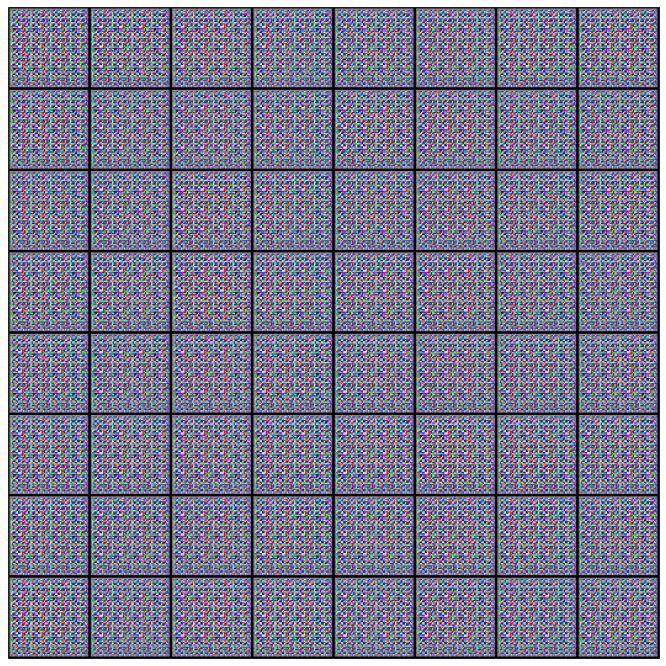

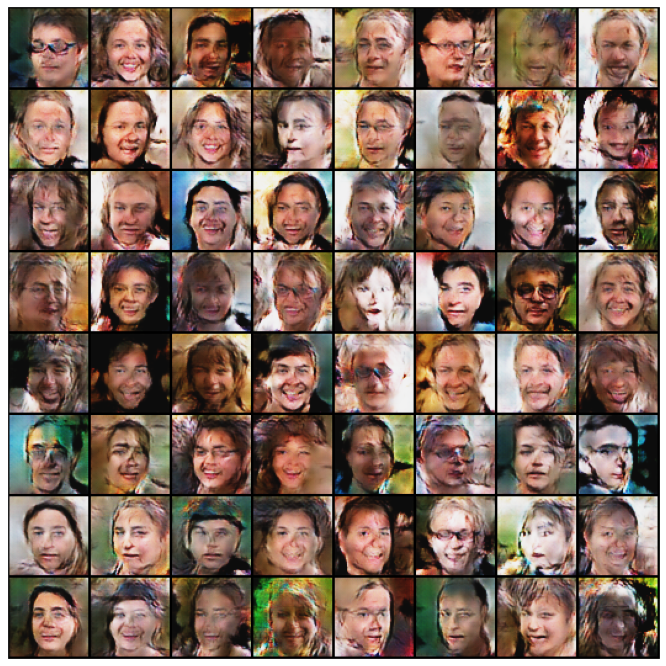

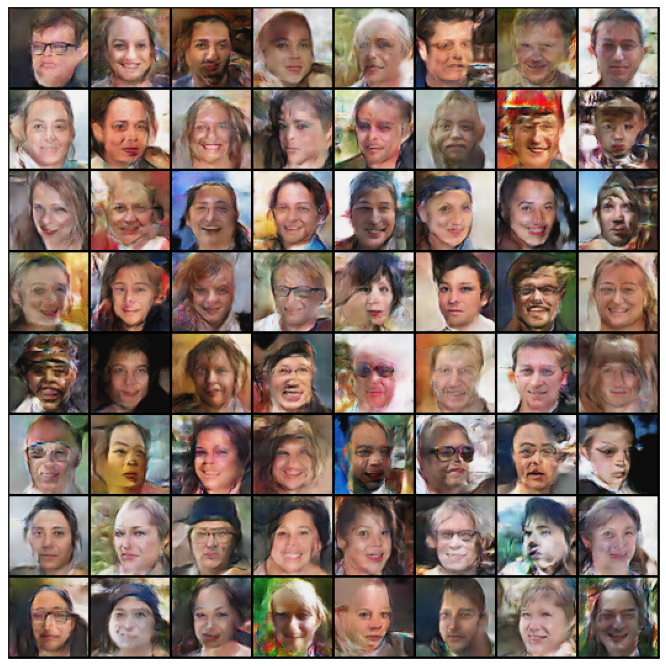

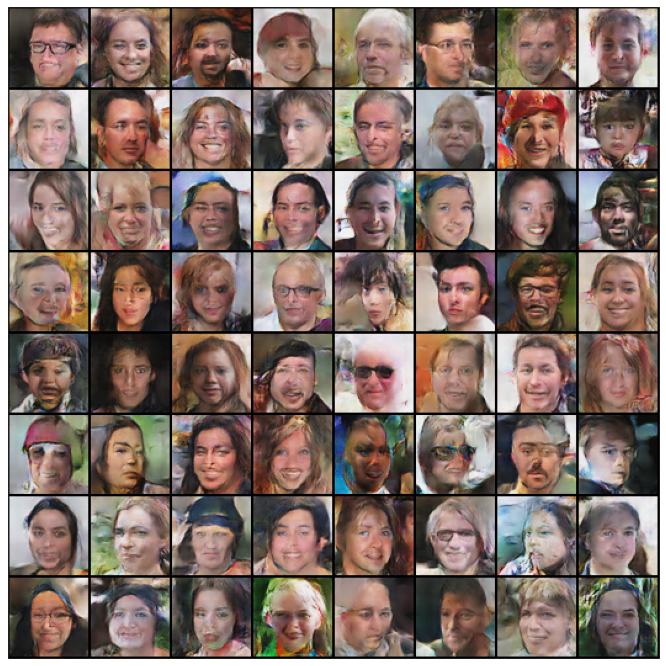

In [22]:
lg, ld, rs, fs = fit(model, criterion, 301, lr=lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

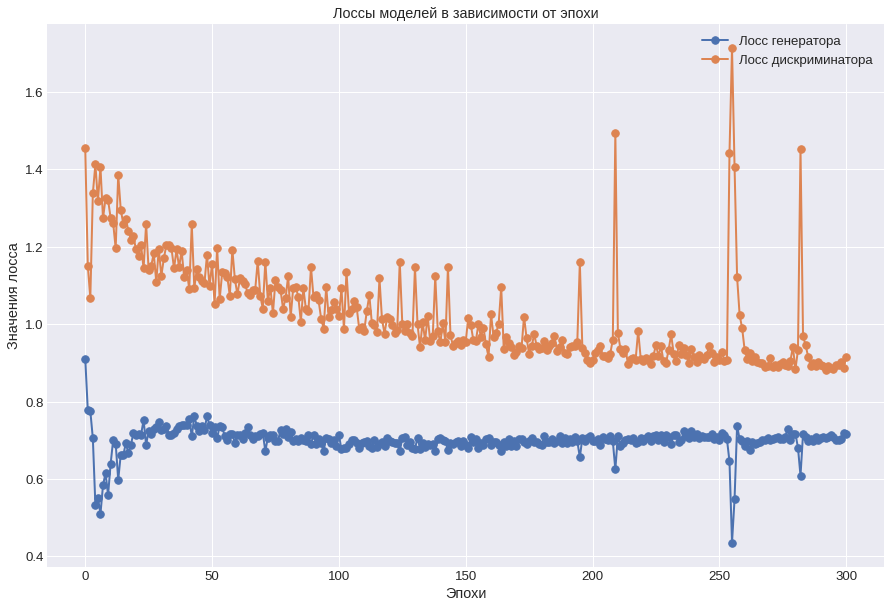

In [27]:
fig, ax =  plt.subplots(figsize = (15,10))
plt.style.use('seaborn-dark')
plt.grid()
steps = range(301)
ax.plot(steps, lg, label='Лосс генератора', linewidth=2, marker ='.', markersize=15)
ax.plot(steps, ld, label='Лосс дискриминатора', linewidth=2, marker='.', markersize=15)

ax.set_xlabel('Эпохи')
ax.set_ylabel('Значения лосса') 
ax.set_title("Лоссы моделей в зависимости от эпохи")
ax.legend(loc='upper right')
pass

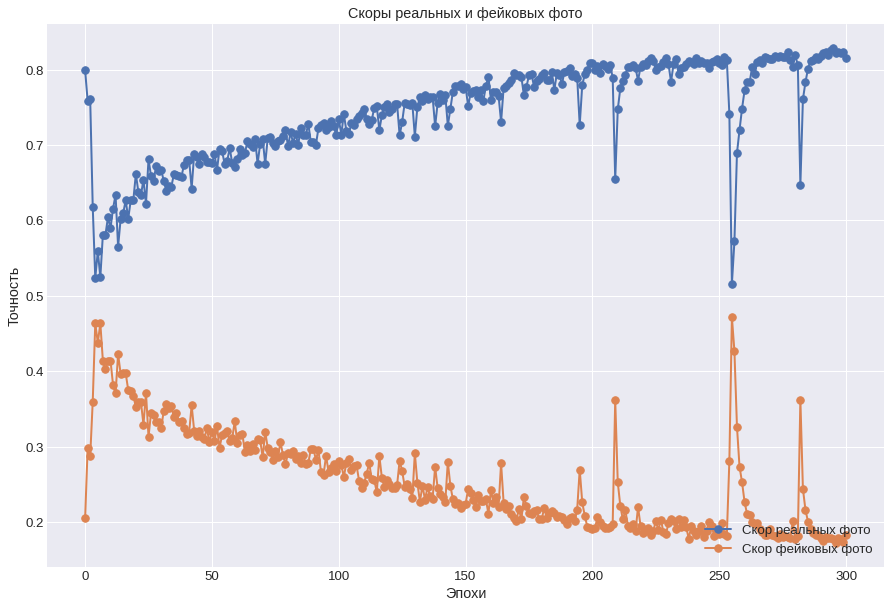

In [26]:
fig, ax =  plt.subplots(figsize = (15,10))
plt.style.use('seaborn-dark')
plt.grid()
steps = range(301)
ax.plot(steps, rs, label='Скор реальных фото', linewidth=2, marker='.', markersize=15)
ax.plot(steps, fs, label='Скор фейковых фото', linewidth=2, marker='.', markersize=15)

ax.set_xlabel('Эпохи')
ax.set_ylabel('Точность') 
ax.set_title("Скоры реальных и фейковых фото")
ax.legend(loc='lower right')
pass

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
gen_weights = generator.state_dict()
torch.save(gen_weights, 'gen_weights.pth')
disc_weights = discriminator.state_dict()
torch.save(disc_weights, 'disc_weights.pth')

In [ ]:
gen_weights = torch.load('gen_weights.pth')
#gen_weights = torch.DoubleTensor(gen_weights)
disc_weights = torch.load('disc_weights.pth')
#disc_weights = torch.DoubleTensor(disc_weights)

In [ ]:
generator.load_state_dict(gen_weights)
discriminator.load_state_dict(disc_weights)

<All keys matched successfully>

In [28]:
n_images = 24

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = denorm(model["generator"](fixed_latent))

In [29]:
fake_images.shape

torch.Size([24, 3, 64, 64])

In [30]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

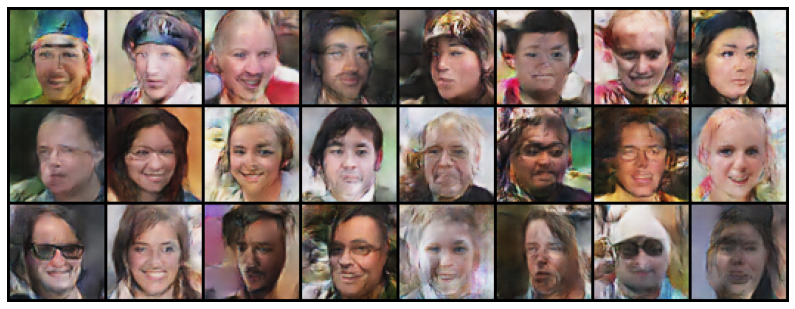

In [31]:
show_images(fake_images.cpu(), nmax=24)

Как вам качество получившихся изображений?

Вполне себе приемлемое :)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [32]:
dl = get_dataloader(image_size,2000)
real_images = next(iter(dl))[0]
y_real = torch.ones(len(real_images))


In [33]:
n_images = 2000
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = denorm(model["generator"](fixed_latent))
y_fake = torch.zeros(len(fake_images))

In [38]:
X = torch.cat((real_images, fake_images.cpu()))
y = torch.cat((y_real, y_fake))

In [36]:
import torchvision.models as models
fmodel = models.mobilenet_v3_small(pretrained=True)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [40]:
fmodel.eval()
with torch.no_grad():
    features  = fmodel.features(X)
print(features.shape)

torch.Size([4000, 576, 2, 2])


In [41]:
ind = np.random.permutation(range(4000))
X = features[ind].detach()
flat = nn.Flatten()
X = flat(X)
y = y[ind]
print(X.shape)

torch.Size([4000, 2304])


In [42]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
ll = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)
correct = 0
iter = 0            
for train_ind, test_ind in ll.split(X):
    if iter % 100 == 0:
        print(f'made {iter} iters')
    iter += 1
    knn.fit(X[train_ind], y[train_ind])
    y_pred = knn.predict(X[test_ind])
    correct += y_pred[0] == y[test_ind].item()

print('Accuracy is', correct/4000)


made 0 iters
made 100 iters
made 200 iters
made 300 iters
made 400 iters
made 500 iters
made 600 iters
made 700 iters
made 800 iters
made 900 iters
made 1000 iters
made 1100 iters
made 1200 iters
made 1300 iters
made 1400 iters
made 1500 iters
made 1600 iters
made 1700 iters
made 1800 iters
made 1900 iters
made 2000 iters
made 2100 iters
made 2200 iters
made 2300 iters
made 2400 iters
made 2500 iters
made 2600 iters
made 2700 iters
made 2800 iters
made 2900 iters
made 3000 iters
made 3100 iters
made 3200 iters
made 3300 iters
made 3400 iters
made 3500 iters
made 3600 iters
made 3700 iters
made 3800 iters
made 3900 iters
Accuracy is 0.73725


В этот раз получилась точность менее, удачная, при предыдущих запусках, ничего не меня получалась точность 0.51. К сожалению тут немного фактор рандома играет роль. А перезапускать тратит слишком много времени

In [43]:
y_fake.shape

torch.Size([2000])

In [44]:
y_real.shape

torch.Size([2000])

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [45]:
from sklearn.manifold import TSNE
vector_2d = TSNE().fit_transform(X.cpu())



/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


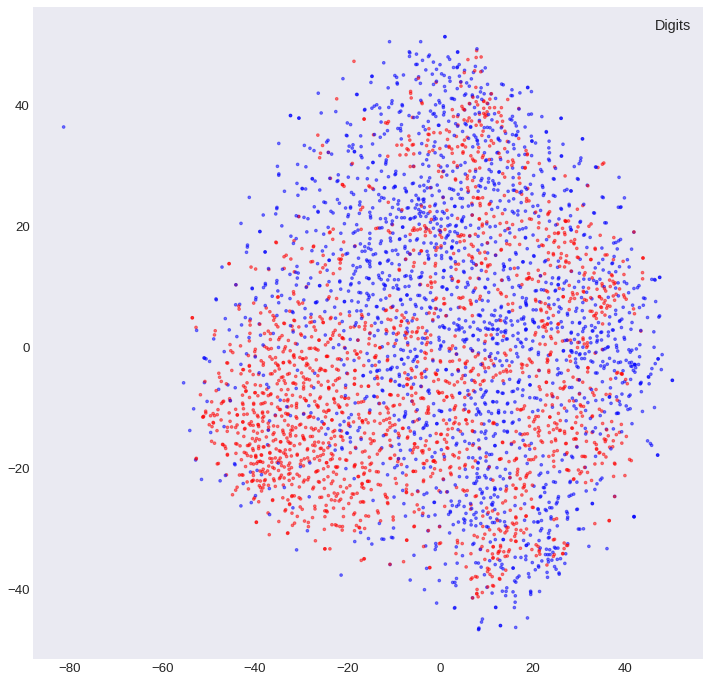

In [63]:
plt.figure(figsize=(12,12))
colors = []
for i in y:
    if i == 0:
        colors.append('red')
    else:
        colors.append('blue')
scatter = plt.scatter(vector_2d[:,0], vector_2d[:,1], c = colors, label = y, alpha = 0.5, s = 7)
legend = plt.legend(*scatter.legend_elements(),loc = 'upper right', title ='Digits')

plt.show()

Прокомментируйте получившийся результат:

видим, что основная часть сгенерированных картинок и реальных смешаны и не могут быть разделены гиперплоскостью, что символизирует о качестве сгенерированных картинок. Правда присутсвуют незначительное количество выбросов среди сгенерированных картинок. При последнем запуске наблюдается небольшая скученность генерированных и реальных картинок, однако, в предыдущих запусках получалось добиваться точности 0.51 и тем самым менее разделяющуюся выборку. Просто каждый раз запускать занимает довольно много времени